In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle


In [ ]:
df = pd.read_csv('housing.csv')
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952

In [ ]:
print(df.isnull().sum())
numeric_df = df.select_dtypes(include=np.number)


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


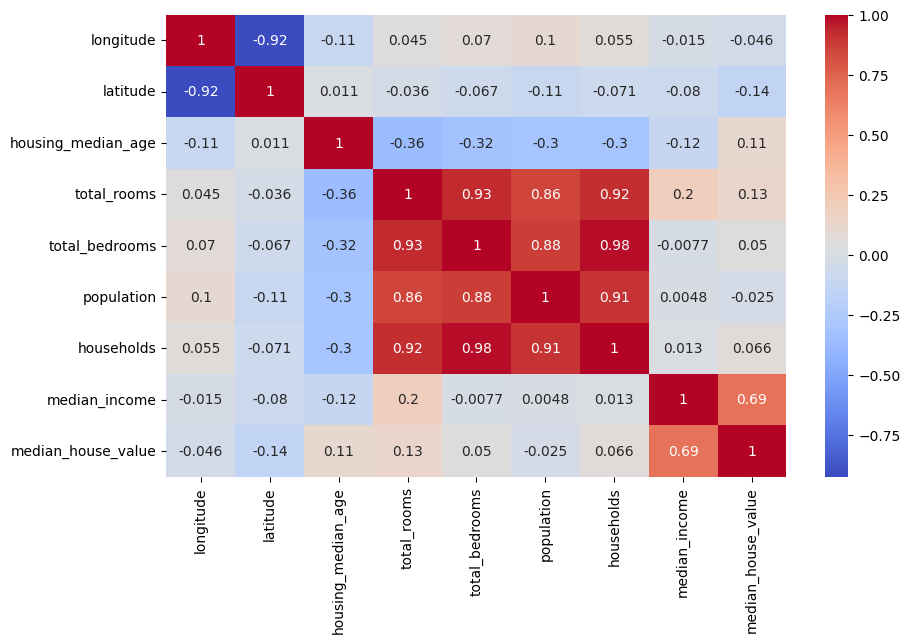

In [ ]:
# Before calling df.corr(), select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# Load dataset
df = pd.read_csv("/content/housing.csv")

# ==============================
# 1️⃣ Handling Missing Values
# ==============================

# KNN Imputation for numerical features (excluding 'median_house_value')
num_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('median_house_value', errors='ignore')
knn_imputer = KNNImputer(n_neighbors=5)
df[num_features] = knn_imputer.fit_transform(df[num_features])

# Median Imputation for skewed features
if 'median_income' in df.columns:
    median_imputer = SimpleImputer(strategy="median")
    df[['median_income']] = median_imputer.fit_transform(df[['median_income']])

# Domain Knowledge Imputation
if 'total_bedrooms' in df.columns and 'total_rooms' in df.columns:
    df['total_bedrooms'].fillna(df['total_rooms'] * 0.2, inplace=True)  # Assume 20% of rooms are bedrooms

print("\n✅ Missing values after imputation:\n", df.isnull().sum())

# ==============================
# 2️⃣ Removing Outliers (Using IQR)
# ==============================

Q1 = df[num_features].quantile(0.25)
Q3 = df[num_features].quantile(0.75)
IQR = Q3 - Q1

# Define outlier removal threshold (excluding target variable)
df = df[~((df[num_features] < (Q1 - 1.5 * IQR)) | (df[num_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("\n✅ Dataset Shape after Outlier Removal:", df.shape)

# ==============================
# 3️⃣ Encoding Categorical Features
# ==============================

if 'ocean_proximity' in df.columns:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_features = encoder.fit_transform(df[['ocean_proximity']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['ocean_proximity']))

    df = df.drop(columns=['ocean_proximity'])
    df = pd.concat([df, encoded_df], axis=1)

print("\n✅ Categorical Encoding Done.")


print("\n✅ Final Dataset Shape:", df.shape)
print("\n🔍 First 5 Rows after Processing:\n", df.head())

# Save the cleaned dataset
df.to_csv("/content/cleaned_housing.csv", index=False)
print("\n✅ Data Cleaning & Preprocessing Completed! File Saved: cleaned_housing.csv")


<ipython-input-7-2bb197de07a5>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(df['total_rooms'] * 0.2, inplace=True)  # Assume 20% of rooms are bedrooms



✅ Missing values after imputation:
 longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

✅ Dataset Shape after Outlier Removal: (18184, 10)

✅ Categorical Encoding Done.

✅ Final Dataset Shape: (20390, 13)

🔍 First 5 Rows after Processing:
    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   
5    -122.25     37.85                52.0        919.0           213.0   
6    -122.25     37.84                52.0       2535.0           489.0   

   population  households  median_income  median_house_value  \
2       496.0       177.0         7.2574  

In [ ]:
# Identify numerical and categorical columns
num_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('median_house_value')
cat_features = df.select_dtypes(include=['object']).columns


# Create preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Before splitting, drop rows with NaN in 'median_house_value'
df = df.dropna(subset=['median_house_value'])  # Drop rows with NaN in target

X = df.drop(columns=['median_house_value'])  # Replace 'Price' with 'median_house_value'
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_transformed, y_train)

# Predictions
y_pred = model.predict(X_test_transformed)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R² Score: {r2}')


RMSE: 50883.98591181134
MAE: 32690.54040692879
R² Score: 0.7720458601523768


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = RandomizedSearchCV(RandomForestRegressor(), param_grid, n_iter=5, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)

best_model = grid_search.best_estimator_
print(grid_search.best_params_)


{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}


In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(optimized_model, f) # Changed best_model to optimized_model

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:
from google.colab import files
files.download('model.pkl')
# files.download('preprocessor.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Load the preprocessor
with open('preprocessor.pkl', 'rb') as file:
    preprocessor = pickle.load(file)

# Check expected column names
print("Expected Columns:", preprocessor.feature_names_in_)



Expected Columns: ['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income'
 'ocean_proximity']
